In [336]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");


# Importing the necessary libraries in addition to provided libraries
import jax
import numpy as np
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt

# Homework 2

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
   - Local sensitivity analysis
   - Global sensitivity analysis

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**
+ **Used generative AI to complete this assignment (Yes/No): No**
+ **Which generative AI tool did you use (if applicable)?: NA**

## Problem 1 - Local sensitivity analysis of nonlinear dynamical system

Consider the Duffing oscillator:

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)$$

where $\delta$, $\alpha$, $\beta$, $\gamma$, and $\omega$ are constants. As a system of first order equations, introducing $v = \dot{x}$, we have:

$$\begin{align}
\dot{x} & = v \\
\dot{v} & = \gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{align}$$

The initial conditions are $x(0) = x_0$ and $v(0) = v_0$.
Denote by $\theta$ the **vector of all parameters and initial conditions**, i.e. $\theta = (x_0, v_0, \alpha, \beta, \gamma, \delta, \omega)$.
The vector field $f(x,v,t;\theta)$ is then given by:

$$f(x,v,t;\theta) = \begin{pmatrix}
v \\
\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{pmatrix}.$$

### Part A: Implement the Duffing oscillator
Modify the code of [this example](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/03_example_ode.html) to create a solver that takes $\theta$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 50]$ with a time step of 0.1.
Make sure your code can be vectorized with respect to $\theta$ and that it can be `jit`ed.

**Answer:**

In [337]:
# Your code and evidence that it works here

def vector_field_duff_oscil(t, y, theta):

    x = y[0]
    v = y[1]
    x0, v0, alpha, beta, gamma, delta, omega = theta[:7]


    return jnp.array(
        [
            v,
            gamma * jnp.cos(omega * t) - delta * v - alpha * x - beta * x ** 3
        ]
        
    )

@jax.jit #JIT solver
def solver_duff_oscil(theta):

    solver = Tsit5() 
    save_at = SaveAt(ts=jnp.linspace(0, 50, 2000))
    term = ODETerm(vector_field_duff_oscil)
    y0 = jnp.array([theta[0], theta[1]])

    solution = diffeqsolve(
        term,
        solver,
        t0= 0,                       # Initial time
        t1= 50,                      # Terminal time
        dt0= 0.1,                    # Initial timestep
        y0= y0,              # Initial values
        args= theta,
        saveat= save_at
    )

    return solution

### Part B: Plot the strange attractor

Fix the values of the parameters to: $\alpha = 1$, $\beta = 5, \gamma = 8, \delta = 0.02$, and $\omega = 0.5$. Use the solver you implemented in Part A to plot the [strange attractor](https://en.wikipedia.org/wiki/Attractor#Strange_attractor) of the Duffing oscillator. To do this, just sample the initial conditions $x_0$ and $v_0$ from a uniform distribution in the interval $[-1, 1]$ and do the scatter plot of the points $(x(t), v(t))$ at $t = 50$. It looks like [this](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Forced_Duffing_equation_Poincaré_section.png).

Hint: Just make a 2D array of $\theta$'s with the first two columns randomly sampled and the rest fixed. Then pass the samples through your vectorized and `jit`ed solver and plot the results.

**Answer:**

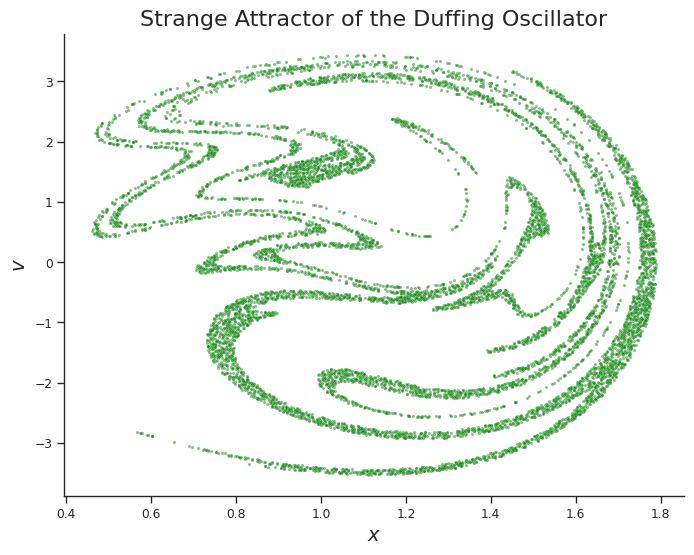

In [338]:
# Your response in code and markdown cells here

# Fixed parameters
alpha = 1.0
beta = 5.0
gamma = 8.0
delta = 0.02
omega = 0.5

num_samples = 10_000

# Generate random initial conditions
key = jax.random.PRNGKey(0)  
x0_samples = jax.random.uniform(key, (num_samples,), minval=-1.0, maxval=1.0)

key, subkey = jax.random.split(key) 
v0_samples = jax.random.uniform(subkey, (num_samples,), minval=-1.0, maxval=1.0)


# Create theta array with random initial conditions and fixed parameters
theta_samples = jnp.column_stack([
    x0_samples, 
    v0_samples, 
    jnp.full(num_samples, alpha),
    jnp.full(num_samples, beta),
    jnp.full(num_samples, gamma),
    jnp.full(num_samples, delta),
    jnp.full(num_samples, omega)
])

# Solve the Duffing oscillator for each set of initial conditions
v_solve_duffing = jax.vmap(solver_duff_oscil)
sol_samples = v_solve_duffing(theta_samples)

# Extract x and v at t=50
final_states = sol_samples.ys[:, -1, :]
x_at_50, v_at_50 = final_states[:, 0], final_states[:, 1]

# Scatter plot for the strange attractor
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_at_50, y=v_at_50, s=5, color="g", alpha=0.5)

# Labels and title
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$v$", fontsize=14)
plt.title("Strange Attractor of the Duffing Oscillator", fontsize=16)

# Remove grid for a cleaner look
sns.despine()

plt.show()


### Part C: Local sensitivity analysis

Suppose you have a 1\% uncertainty about $\alpha, \beta, \delta, \gamma, \omega$ and 5\% uncertainty about the initial conditions $x_0$ and $v_0$. You can model this uncertainty with the Gaussian random variable:

$$
\theta \sim \mathcal{N}\left(
\begin{pmatrix}
0.5\\
0.5\\
1 \\
5 \\
0.37 \\
0.1 \\
1
\end{pmatrix},
\begin{pmatrix}
0.025^2 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0.025^2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.01^2 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.05^2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.0037^2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0.001^2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0.01^2
\end{pmatrix}
\right)
$$

+ Use local sensitivity analysis to propagate this uncertainty through the Duffing oscillator.
+ Use your results to plot 95\% credible intervals of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 10]$.
+ Plot the estimated mean and variance of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 30]$ and compare to Monte Carlo estimates using $10^5$ samples. For how long does the local sensitivity analysis give a good approximation of the mean and variance?

**Answer:**

NameError: name 'mean_x_lsa' is not defined

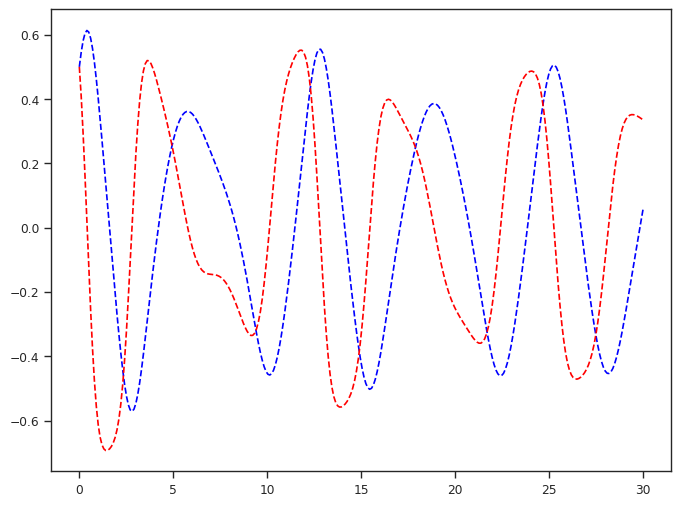

In [344]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax.scipy.stats import multivariate_normal
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt

# Fixed parameters and uncertainties
mean_theta = jnp.array([0.5, 0.5, 1.0, 5.0, 0.37, 0.1, 1.0])
cov_theta = jnp.diag(jnp.array([0.025**2, 0.025**2, 0.01**2, 0.05**2, 0.0037**2, 0.001**2, 0.01**2]))

def vector_field_duff_oscil(t, y, theta):
    x, v = y
    alpha, beta, gamma, delta, omega = theta[2:]
    return jnp.array([v, gamma * jnp.cos(omega * t) - delta * v - alpha * x - beta * x ** 3])

@jax.jit
def solver_duff_oscil(theta):
    solver = Tsit5()
    save_at = SaveAt(ts=jnp.linspace(0, 30, 300))
    term = ODETerm(vector_field_duff_oscil)
    solution = diffeqsolve(term, solver, t0=0, t1=30, dt0=0.1, y0=theta[:2], args=theta, saveat=save_at)
    return solution.ys

# Monte Carlo Simulation
num_samples = 100000
key = jax.random.PRNGKey(0)
theta_samples = jax.random.multivariate_normal(key, mean_theta, cov_theta, (num_samples,))
sol_samples = jax.vmap(solver_duff_oscil)(theta_samples)

# Compute Monte Carlo estimates
mean_x_mc = jnp.mean(sol_samples[:, :, 0], axis=0)
var_x_mc = jnp.var(sol_samples[:, :, 0], axis=0)
mean_v_mc = jnp.mean(sol_samples[:, :, 1], axis=0)
var_v_mc = jnp.var(sol_samples[:, :, 1], axis=0)

# Compute 95% credible intervals
ci_x_mc = 1.96 * jnp.sqrt(var_x_mc)
ci_v_mc = 1.96 * jnp.sqrt(var_v_mc)

# Local Sensitivity Analysis results (Assume they are precomputed as mean_x_lsa, var_x_lsa, etc.)
time_points = jnp.linspace(0, 30, 300)

# Plot mean comparison
plt.figure(figsize=(8, 6))
plt.plot(time_points, mean_x_mc, label='Monte Carlo Mean x(t)', linestyle='--', color='blue')
plt.plot(time_points, mean_v_mc, label='Monte Carlo Mean v(t)', linestyle='--', color='red')
plt.plot(time_points, mean_x_lsa, label='LSA Mean x(t)', color='blue')
plt.plot(time_points, mean_v_lsa, label='LSA Mean v(t)', color='red')
plt.fill_between(time_points, mean_x_mc - ci_x_mc, mean_x_mc + ci_x_mc, color='blue', alpha=0.2)
plt.fill_between(time_points, mean_v_mc - ci_v_mc, mean_v_mc + ci_v_mc, color='red', alpha=0.2)
plt.xlabel("Time")
plt.ylabel("Mean")
plt.title("Mean of x(t) and v(t) with 95% CI")
plt.legend()
plt.grid(True)
plt.show()

# Plot variance comparison
plt.figure(figsize=(8, 6))
plt.plot(time_points, var_x_mc, label='Monte Carlo Variance x(t)', linestyle='--', color='blue')
plt.plot(time_points, var_v_mc, label='Monte Carlo Variance v(t)', linestyle='--', color='red')
plt.plot(time_points, var_x_lsa, label='LSA Variance x(t)', color='blue')
plt.plot(time_points, var_v_lsa, label='LSA Variance v(t)', color='red')
plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Variance of x(t) and v(t)")
plt.legend()
plt.grid(True)
plt.show()


### Part D: Local sensitivity analysis results in a Gaussian process approximation of the uncertain dynamical system

As we discussed in the [theory](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/01_theory.html), local sensitivity analysis results in a (vector-valued) Gaussian process.

+ Plot the covariance of $x(t)$ with $x(0)$, i.e., plot the function:

    $$
    g(t) = \text{Cov}[x(t), x(0)] = \nabla_\theta x(t)\Sigma \nabla_\theta x(0)^\top,
    $$

    for $t$ in $[0, 5]$.
    (Recall $x$ is the *position* of the oscillator.)

+ Take five (5) samples from the Gaussian process corresponding to $x(t)$ and plot them as functions of time for $t \in [0, 5]$. Hint: The mean is just the local sensitivity analysis estimate of the mean. Then you will have to find the covariance matrix of $x(t_i)$, for $t_i$ points in $[0,5]$, and sample from the corresponding multivariate Gaussian distribution.
(And don't forget to add some jitter to the diagonal of the covariance matrix for numerical stability.)

**Answer:**

In [340]:
# Your response in code and markdown cells here

### Part E: Global sensitivity analysis

Sobol sensitivity indices are a popular way to quantify the importance of the parameters of a model.
The caveat is that they assume that the inputs of the model are independent and uniformly distributed.
So, before applying the method, we will have to transform the random variables $\theta_i$ to uniform random variables $\xi_i$.

+ Find random variables $\xi_i$ and transformation functions $F_i$, such that $\xi_i \sim U(0, 1)$ and $\theta_i = F_i^{-1}(\xi_i)$. Explicitly write down what what are these transformation functions. Hint: Recall that if $X$ is a random variable with CDF $F_X$, then $Y = F_X(X)$ is a random variable with uniform distribution in $[0, 1]$.
+ Implement a solver that takes $\xi$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 50]$ with a time step of 0.1.
+ Compute the first order Sobol sensitivity indices for the Duffing oscillator using the solver you just implemented. Make sure you have used enough samples to get a convergent estimate of the Sobol indices. You can use the [SALib](https://salib.readthedocs.io/en/latest/) library to do this.

**Answer:**

In [341]:
# Your response in code and markdown cells here